### Copyright Pavel Nakaznenko, 2023
### For Sber beautiful code contest
### pavel@nakaznenko.com

# Setup

In [ ]:
!pip install pandas==2.0.3 numpy seaborn matplotlib scikit-learn xgboost

# Описание

**Алгоритм классификации:**

Я честно погуглил prior art на тему и самые многообещающие результаты показал градиентный бустинг.
Поэтому я решил следовать этому направлению, опираясь на успехи и опыт сообщества.
Мои мысли на тему преимуществ этого метода:

-Эффективность в борьбе с переобучением

-Способность обрабатывать большое количество признаков

-Нет необходимости в масштабировании признаков (в отличие от логистической регрессии)

-Высокая устойчивость к выбросам

Более того, градиентный бустинг дает четкое понимание важности признаков.

**Преобразование данных:**


TF-IDF векторизация. Этот метод преобразует текстовые данные в числовой формат, учитывая значимость каждого символа или слова для всего датасета. На мой взгляд, он эффективнее One-Hot-Encoding, особенно в сочетании с градиентным бустингом, так как учитывает специфические особенности текста, такие как регистр символов или длина пароля.

**Метрика качества:**


В нашем контексте больше ценится точность (precision) нежели accuracy, чтобы не угрожать безопасности. Кроме того, для попытки более глубокого анализа будем использовать оценку важности признаков. Для оптимизации выбора гиперпараметров применим RandomizedSearch

# Загрузка и обработка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier


from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    precision_score, 
    classification_report, 
    confusion_matrix
)

In [2]:
data = pd.read_csv('passwords.csv')

# Предварительная обработка
# Удаление строк с пропущенными значениями
data.dropna(subset=['password', 'strength'], inplace=True)

In [3]:
# Проверка сбалансированности датасета
class_counts = data['strength'].value_counts()
print("Class distribution:\n", class_counts)

Class distribution:
 strength
1    74278
0    13428
2    12294
Name: count, dtype: int64


У нас тут явный дисбаланс. Давайте сделаем downsample.

In [4]:
# даунсэмплинг для устранения дисбаланса классов
min_class_samples = class_counts.min()

# Функция для даунсэмплинга
def downsample_class(data, strength, n_samples):
    class_samples = data[data['strength'] == strength]
    downsampled_class = class_samples.sample(n_samples, random_state=42)
    return downsampled_class

# Применение функции даунсэмплинга для каждого класса
data = pd.concat([
    downsample_class(data, label, min_class_samples) for label in class_counts.index
])

# Проверка сбалансированности после даунсэмплинга
print("Class distribution after downsampling:\n", data['strength'].value_counts())

Class distribution after downsampling:
 strength
1    12294
0    12294
2    12294
Name: count, dtype: int64


In [5]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    data['password'], data['strength'], test_size=0.2, random_state=42
)

# TF-IDF векторизация
vectorizer = TfidfVectorizer(analyzer='char')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Учим

In [6]:
# Настройка гиперпараметров с помощью RandomizedSearchCV
param_dist = {
    'n_estimators': np.arange(50, 201, 50), # количество деревьев
    'max_depth': np.arange(3, 10), # глубина деревьев
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3], # коэфициент обучения
    'subsample': np.arange(0.5, 1.0, 0.1), # доля выборки для каждого дерева
    'colsample_bytree': np.arange(0.5, 1.0, 0.1), # доля признаков для каждого дерева
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5], # регуляризация
    'num_class': [len(data['strength'].unique())] # кол-во классов
}

# испольтзуем гистограмный метод для градиентного бустинга
xgb_c = XGBClassifier(tree_method='hist', objective=['multi:softmax'])

random_search = RandomizedSearchCV(
    xgb_c, param_distributions=param_dist, n_iter=10, cv=3, verbose=1
)
random_search.fit(X_train_vec, y_train)

best_xgb_c = random_search.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


# Предсказываем

In [7]:
y_pred = best_xgb_c.predict(X_test_vec)

In [8]:
# Оценка модели
print("Precision:", precision_score(y_test, y_pred, average='weighted'))  # используем 'weighted', чтобы учесть дисбаланс классов
print(classification_report(y_test, y_pred))

Precision: 0.9740854360107254
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2442
           1       0.97      0.95      0.96      2471
           2       0.97      0.99      0.98      2464

    accuracy                           0.97      7377
   macro avg       0.97      0.97      0.97      7377
weighted avg       0.97      0.97      0.97      7377



In [9]:
# Важность признаков
importances = best_xgb_c.feature_importances_
indices = np.argsort(importances)[::-1]

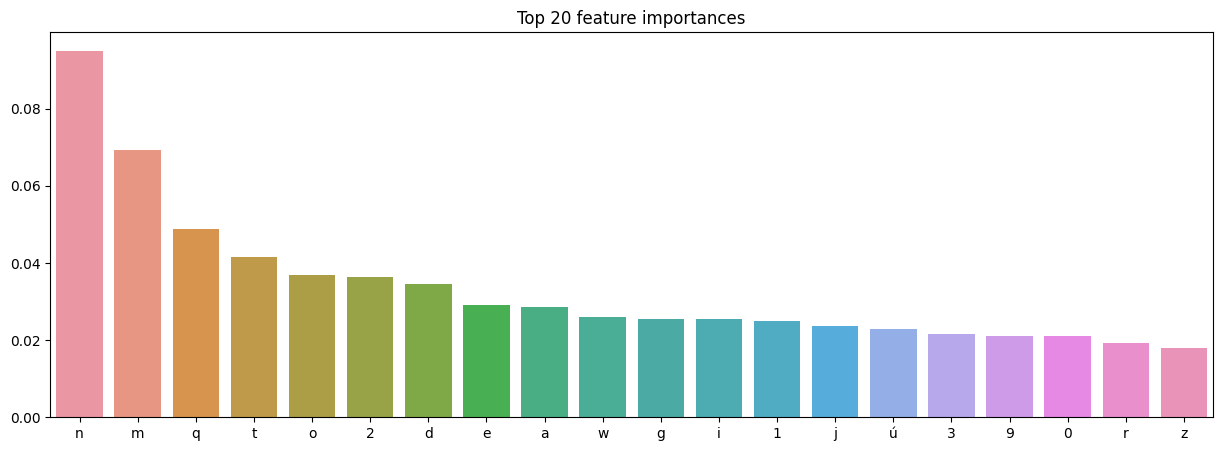

In [10]:
# Вывод топ-20 наиболее важных признаков
plt.figure(figsize=(15, 5))
sns.barplot(
    x=np.array(vectorizer.get_feature_names_out())[indices[:20]],
    y=importances[indices[:20]]
)
plt.title("Top 20 feature importances")
plt.show()

In [11]:
# Функция проверки нового пароля
def check_password_strength(password):
    password_vec = vectorizer.transform([password])
    return best_xgb_c.predict(password_vec)[0]

In [12]:
# Проверяем пароль
new_password = "examplePassword123"
print(check_password_strength(new_password))

2
